# Inverse design of 3dB power splitter (3D)

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from IPython.display import Video
from autograd import tensor_jacobian_product
import nlopt
mp.verbosity(0) ############################


1.27.0


1

current beta:  8
Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


/Users/satadru/anaconda3/envs/meep/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


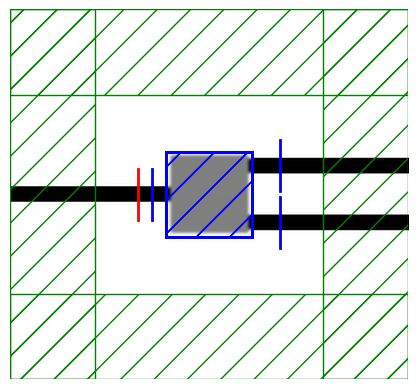

Average through transmission is :  2.1404581754636465
Average cross transmission is :  2.1408438924669992


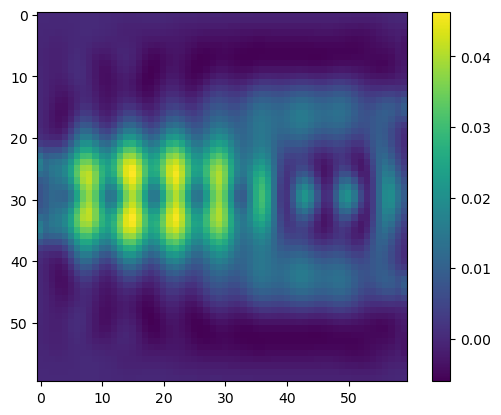

Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...


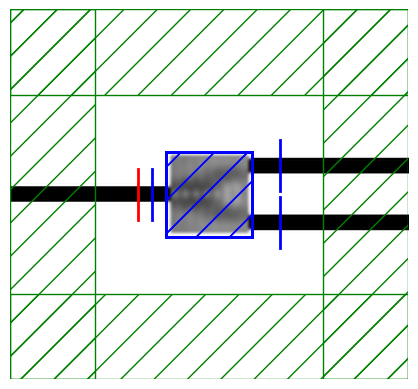

Average through transmission is :  5.8302385059708755
Average cross transmission is :  5.8314868192611575


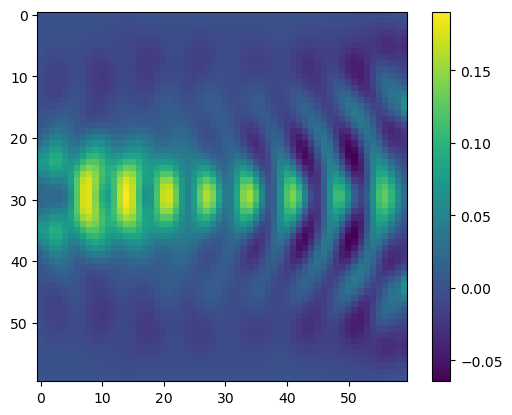

Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...


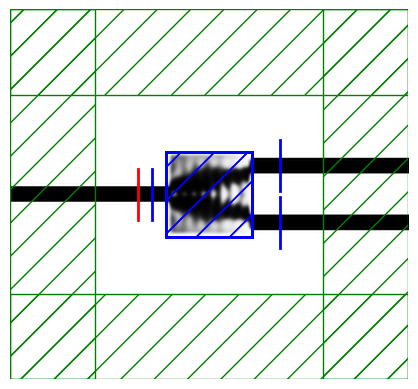

Average through transmission is :  10.028638494609755
Average cross transmission is :  10.027703754275864


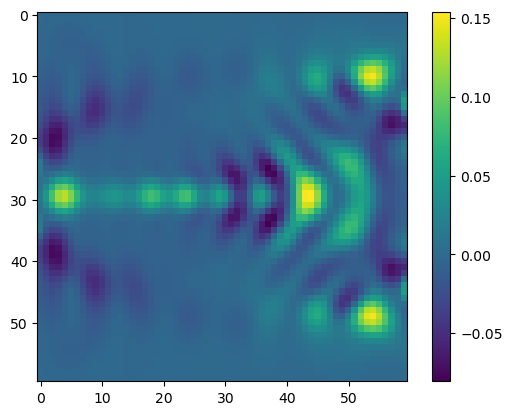

Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


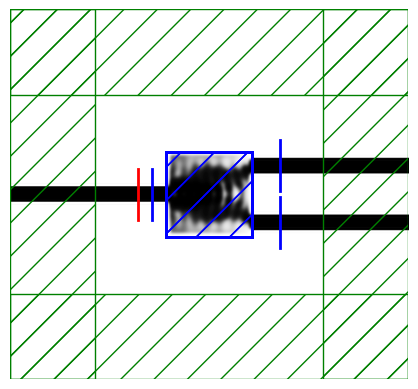

Average through transmission is :  1.9779583187979384
Average cross transmission is :  1.9785881738740279


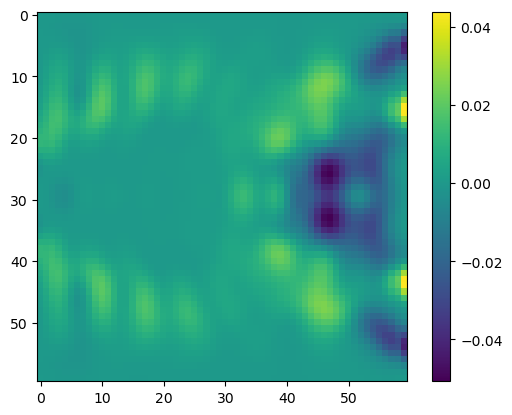

Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...


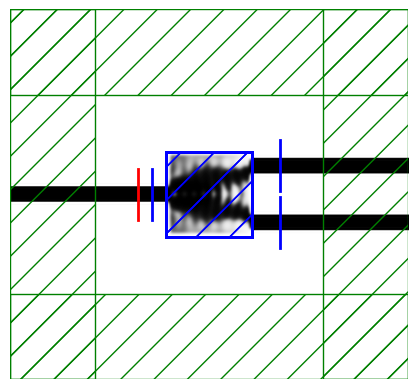

Average through transmission is :  8.274387871737257
Average cross transmission is :  8.274970906327654


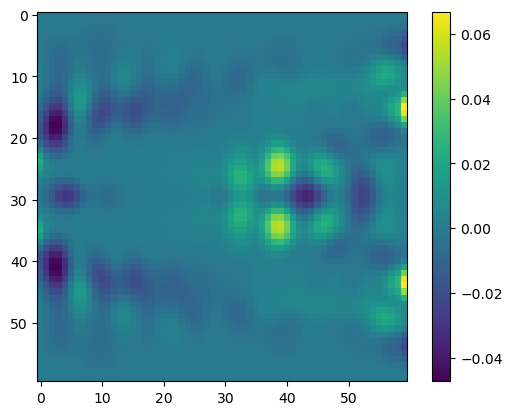

Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...


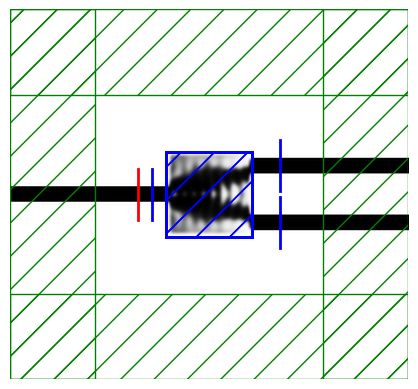

Average through transmission is :  10.551826914592812
Average cross transmission is :  10.551653268591428


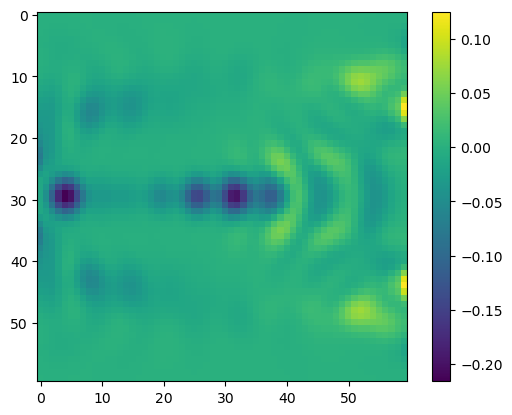

Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...


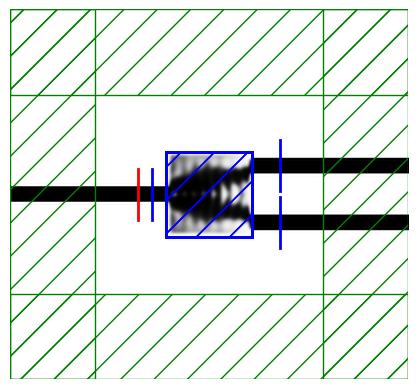

Average through transmission is :  10.074101918058961
Average cross transmission is :  10.07421292750014


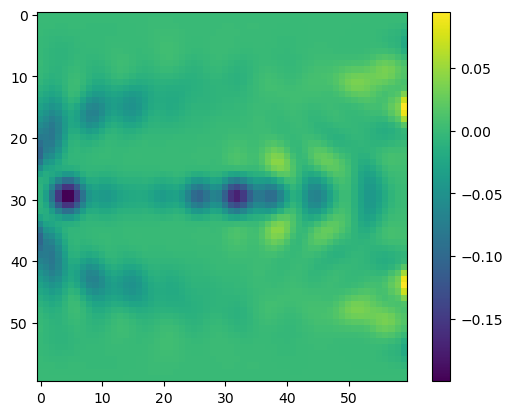

Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


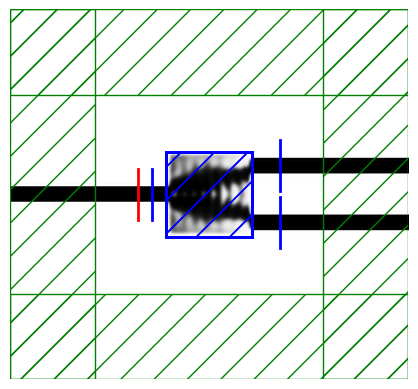

Average through transmission is :  10.415143645243246
Average cross transmission is :  10.415075023105171


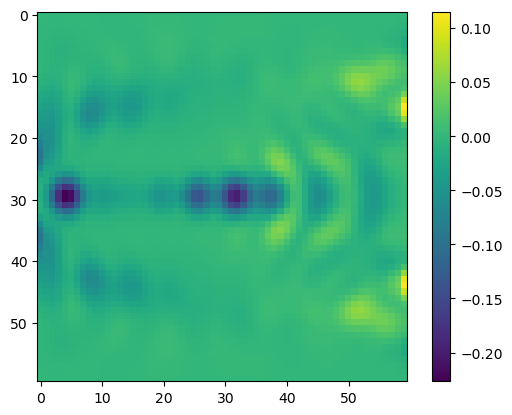

Current iteration: 9
Starting forward run...


KeyboardInterrupt: 

In [2]:
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

waveguide_width = 0.5
design_region_width = 3
design_region_height = 3
arm_separation = 2
waveguide_length = 0.5
t_Si = 0.21
pml_size = 3
resolution = 20
t_oxide = 0.5
minimum_length = 0.08
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e
design_region_resolution = int(resolution)
frequencies = 1 / np.linspace(1.5, 1.6, 10)
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width +4
Sy = 2 * pml_size + design_region_height + 4
Sz = 2* pml_size + 5*t_oxide + t_Si + 2
cell_size = mp.Vector3(Sx, Sy, Sz)
pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.56
width = 0.2
fwidth = width * fcen
source_center = [-design_region_width/2 - 1  , 0, 0]
source_size = mp.Vector3(0, 1.8, 1.8)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]


Nx = int(design_region_resolution * design_region_width) 
Ny = int(design_region_resolution * design_region_height) 

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN", do_averaging = False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, t_Si),
    ),
)


def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()


# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

# Define the core mask
left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation / 2) <= waveguide_width / 2
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation / 2) <= waveguide_width / 2
)
Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4),
        material=Si,
        size=mp.Vector3(Sx / 2 + 1, waveguide_width, t_Si),
    ),  # left waveguide
    mp.Block(
        center=mp.Vector3(x=Sx / 4, y=arm_separation / 2),
        material=Si,
        size=mp.Vector3(Sx / 2 + 1, waveguide_width, t_Si),
    ),  # top right waveguide
    mp.Block(
        center=mp.Vector3(x=Sx / 4, y=-arm_separation / 2),
        material=Si,
        size=mp.Vector3(Sx / 2 + 1, waveguide_width, t_Si),
    ),  # bottom right waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    symmetries=[mp.Mirror(direction=mp.Y)],
    default_material=SiO2,
    resolution=resolution,
    eps_averaging = True,
)

mode = 1

TE0 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(x=-design_region_width/2 -0.5),
        size=mp.Vector3(y=1.8 , z= 1.8),
    ),
    mode,
)
TE_top = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(
            design_region_width/2 + 1, arm_separation/2, 0
        ),
        size=mp.Vector3(y=1.8, z = 1.8),
    ),
    mode,
)
TE_bottom = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(
            design_region_width/2 + 1, -arm_separation / 2, 0
        ),
        size=mp.Vector3(y=1.8, z = 1.8),
    ),
    mode,
)
ob_list = [TE0, TE_top, TE_bottom]


def J(source, top, bottom):
    power = npa.abs(top / source) ** 2 + npa.abs(bottom / source) ** 2
    return npa.mean(power)


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-5,
)


evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(True, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,0)))
    #circ = Circle((2, 2), minimum_length / 2)
    #ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )
    evaluation_history.append(np.max(np.real(f0)))
    source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()
    top_profile = np.abs(top_coef / source_coef) ** 2
    bottom_profile = np.abs(bottom_ceof / source_coef) ** 2

    print("Average through transmission is : ", np.average(top_profile))
    print("Average cross transmission is : ", np.average(bottom_profile))
       
    plt.figure()
    backprop_gradient = tensor_jacobian_product(mapping,0)(v, eta_i,cur_beta,dJ_du[:,0])
    plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
    plt.colorbar()    
    plt.show()
    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 8
beta_scale = 4
num_betas = 10
update_factor = 30
for iters in range(num_betas):
    print("current beta: ", cur_beta)

    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale


### The errors appear above because I terminated the cell execution midway

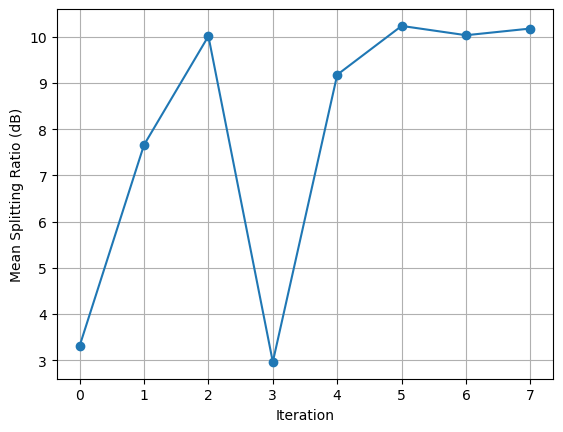

In [3]:
## check the the quantities, they aren't right

plt.figure()
plt.plot(10*np.log10(0.5*np.array(evaluation_history)),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Mean Splitting Ratio (dB)')
plt.show()

In [4]:
f0, dJ_du = opt([mapping(x,eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2


Starting forward run...


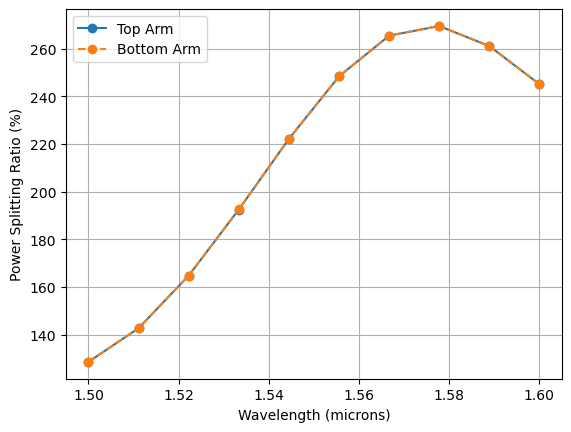

In [5]:
## check the the quantities, they aren't right


plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()